In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.connectome import Connectome
from src.utils import load_preprocessed_connectome
from src.node_ops import segment_skeleton, find_end_points, find_central_segment, measure_path_lengths, seg_length, measure_seg_distances
from vis.fig_tools import subtype_cm

plt.rcdefaults()
plt.style.use('vis/lamina.mplstyle')

In [3]:
tp = '200507'
C = load_preprocessed_connectome(f"~/Data/{tp}_lamina/")

Pickle loaded from: /mnt/home/nchua/Data/200507_lamina/200507_preprocessed.pickle


In [10]:
subtypes = ['LMC_1', 'LMC_2', 'LMC_3', 'LMC_4']#, 'LMC_3', 'LMC_4']#, 'LMC_N']#, 'R7', 'R8', 'R7p']
results = []  

central_segs = dict()
branch_segs = dict()
seg_lengths = dict()
seg_distances = dict()

for skel_id, data in C.skel_data.items():
    if data.subtype not in subtypes:
        continue
    else:
        #these_nodes = [n for n in data.skel_nodes if n not in data.r_nodes]
        # Dict of branch segments (list of contiguous nodes between branch points and leaf nodes)
        branch_segs[skel_id] = segment_skeleton(skel_id, C.cfg, node_data=data.skel_nodes, restrict_nodes=data.r_nodes)
        # List of nodes along the 'backbone'
        central_segs[skel_id] = find_central_segment(skel_id, 'lamina_end', C.cfg, node_data=data.skel_nodes)
        # measure path lengths of each segment
        seg_lengths[skel_id] = measure_path_lengths(branch_segs[skel_id], cfg=C.cfg, node_data=data.skel_nodes)
        seg_distances[skel_id] = measure_seg_distances(branch_segs[skel_id], cfg=C.cfg, node_data=data.skel_nodes)
        
        results.append({'name': data.name,
                        'skel_id': data.skel_id,
                        'om': data.group,
                        'subtype': data.subtype,
                        'n_central_nodes': len(central_segs[skel_id]), 
                        'n_total_nodes': len(data.skel_nodes), 
                        'n_branch_points': len(branch_segs[skel_id])})#,
                        #'total_path_length': sum([v for k, v in seg_lengths[skel_id].items()])})
        

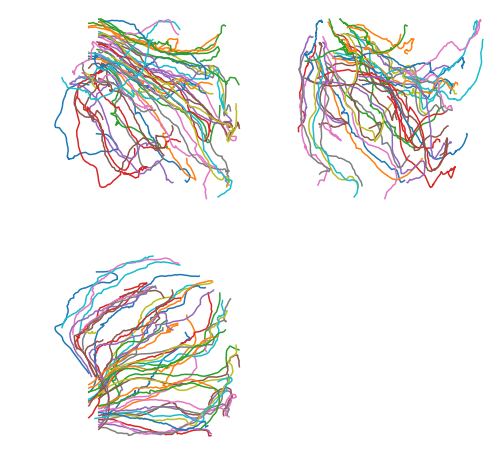

In [12]:
### TESTING ###
# 1. visualize random sample of central segments
fig, ax = plt.subplots(2, 2, figsize=[8, 8])
skel_sample = random.sample(list(central_segs.keys()), 50)

for s, central in central_segs.items():
    if s not in skel_sample:
        continue
    coord_map = {data[0]: data[3:6] for data in C.skel_data[s].skel_nodes}
    x, y, z = np.array([coord_map[n] for n in central]).T

    ax[0,0].plot(x, y)
    ax[0,1].plot(z, y)
    ax[1,0].plot(x, z)
ax[0, 0].axis('off')
ax[0, 1].axis('off')
ax[1, 0].axis('off')
ax[1, 1].remove()

plt.show()

loose end: 13063, A3_L3

In [36]:
# 2. Visualize a random neurite's central segs vs their branches
fig, ax = plt.subplots(2, 2, figsize=[8, 8], aspect='equal')
skel_sample = random.sample(list(central_segs.keys()), 1)

for s, central in central_segs.items():
    if s not in skel_sample:
        continue
        
    print(s)
    print(C.skel_data[s].name)
    coord_map = {data[0]: data[3:6] for data in C.skel_data[s].skel_nodes}
    for b, seg in branch_segs[s].items():
        x, y, z = np.array([coord_map[n] for n in seg]).T
        if (b in central):
            ax[0,0].plot(x, y, c='r')
            ax[0,1].plot(z, y, c='r')
            ax[1,0].plot(x, z, c='r')
        else:
            ax[0,0].plot(x, y, c='g')
            ax[0,1].plot(z, y, c='g')
            ax[1,0].plot(x, z, c='g')
    
ax[0,0].set_title(C.skel_data[skel_sample[0]].name)
ax[0, 0].axis('off')
ax[0, 1].axis('off')
ax[1, 0].axis('off')
ax[1, 1].remove()
plt.show()

TypeError: __init__() got an unexpected keyword argument 'aspect'

Histograms of path length and seg distance

In [20]:
df = pd.DataFrame(results)
type(df.skel_id[0])

str

7050.6497353642535
13538.118508831898
10354.382502109916
8558.491980163863


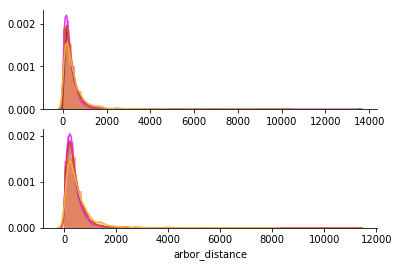

In [32]:

length_data = []


for i, data in df.iterrows():
    this_id = data['skel_id']  #str
    arbors = [s for s in branch_segs[this_id].keys() if int(s) not in central_segs[this_id]]
    
    for a in arbors:
        length_data.append({'skel_id': this_id, 
                            'subtype': data['subtype'],
                            'om': data['om'], 
                            'arbor_node': a, 
                            'arbor_length': seg_lengths[this_id][a], 
                            'arbor_distance': seg_distances[this_id][a]})
length_data = pd.DataFrame(length_data)
fig, ax = plt.subplots(2)
st_cm = subtype_cm()

for s, rows in length_data.groupby('subtype'):
    sns.distplot(rows['arbor_length'], ax=ax[0], color=st_cm[s], label='L'+ s[-1])
    sns.distplot(rows['arbor_distance'], ax=ax[1], color=st_cm[s], label='L'+ s[-1])
    
    print(rows['arbor_length'].max())


In [ ]:

df.head()

In [ ]:

for i, skel_data in df.iterrows():
    
    this_skel = skel_data['skel_id']
    
    if this_skel != '8145':
        continue
    
    this_central = central_segs[this_skel]
    branches = branch_segs[this_skel]
    
    print(this_central)
    print(branches)
    for b, bseg in branches.items():
        print(f"branch {b}, {len(bseg)} nodes, {len(list(set(bseg) & set(this_central)))} in central")
    #df.loc[i, 'arbor_path_length'] = sum([v for k, v in seg_lengths[skel_id].items() if ])

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=[10, 5])

for i, s in enumerate(['n_branch_points', 'n_central_nodes', 'n_total_nodes']):
    x = df.groupby('om')[s].mean()
    y = df.groupby('om')[s].var()
    axes[0, i].scatter(x, y)
    axes[0, i].set_title(s)
    
    x = df.groupby('subtype')[s].mean()
    y = df.groupby('subtype')[s].var()
    axes[1, i].scatter(x, y)
    
plt.show()

In [ ]:
df = pd.DataFrame(results)
df['n_den_nodes'] = df['n_total_nodes'] - df['n_central_nodes']
df['ratio'] = df['n_den_nodes'] / df['n_total_nodes']

In [ ]:
#{b: seg for b, seg in branch_segs['47823'].items() if b not in central_segs['47823'] & seg[-1] not in central_segs['']}
test_skel = '12794'
print(C.skel_data[test_skel].name)

p = path_lengths(branch_segs[test_skel], node_list=C.skel_data[test_skel].skel_nodes)
c = central_segs[test_skel]

In [ ]:
total = sum([v for k, v in p.items()])
branch_total = sum([v for k, v in p.items() if k not in c])
central_total = seg_length(c, C.cfg, {data[0]: data[2:5] for data in C.skel_data[test_skel].skel_nodes})

print(total)
print(total - central_total)
print(branch_total)
print(central_total)

In [ ]:
print(C.skel_data['47823'].name)
some_branch_nodes = list(branch_segs['47823'].keys())
this_center_segment = central_segs['47823']

union = lambda l1, l2 : list(set(l1) & set(l2))

union(some_branch_nodes, this_center_segment)
